In [1]:
# ===== File I/O and System Utilities =====
import os
import re
import io
from collections import defaultdict, Counter

# ===== Numerical and Data Processing =====
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler

# ===== Visualization =====
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# ===== TensorFlow / Keras for LSTM Autoencoder =====
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ===== Anomaly Scoring Utilities =====
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import mahalanobis

# ===== Colab Utilities =====
from google.colab import files

# ===== Warnings =====
import warnings
warnings.filterwarnings('ignore')

# Optional: Adjust default plot size
plt.rcParams['figure.figsize'] = (14, 6)


In [2]:
# ========== File Upload ==========
print("📂 Please upload your candump logs (normal.log, attack.log)...")
uploaded = files.upload()

# Validate required logs
required_logs = ['normal.log', 'attack.log']
for fname in required_logs:
    if fname not in uploaded:
        raise FileNotFoundError(f"❌ Required log file '{fname}' not uploaded.")

print("✅ Logs uploaded successfully!")

# ========== Robust Candump Parser ==========

def parse_candump(filepath):
    """
    Parses a candump log file into a structured DataFrame.
    Returns: DataFrame with timestamp, can_id, and byte_0...byte_n
    """
    parsed = []
    pattern = re.compile(r"\((\d+\.\d+)\)\s+\w+\s+([0-9A-Fa-f]+)#([0-9A-Fa-f]*)")

    try:
        with open(filepath, 'r') as f:
            for i, line in enumerate(f):
                match = pattern.match(line)
                if match:
                    timestamp = float(match.group(1))
                    can_id = int(match.group(2), 16)
                    data = match.group(3)
                    byte_vals = [int(data[i:i+2], 16) for i in range(0, len(data), 2)] if data else []
                    parsed.append([timestamp, can_id] + byte_vals)
                else:
                    print(f"⚠️ Line skipped (malformed or unmatched): {line.strip()}")
    except Exception as e:
        print(f"❌ Error parsing file {filepath}: {e}")
        raise

    if not parsed:
        raise ValueError("❌ No valid CAN frames parsed from log.")

    # Standardize byte length (pad to max observed)
    max_len = max(len(row) for row in parsed)
    padded = [row + [0] * (max_len - len(row)) for row in parsed]
    byte_cols = [f'byte_{i}' for i in range(max_len - 2)]
    cols = ['timestamp', 'can_id'] + byte_cols

    df = pd.DataFrame(padded, columns=cols)
    df['can_id_hex'] = df['can_id'].apply(lambda x: hex(x))
    return df

# ========== Parse Both Logs ==========
try:
    df_normal = parse_candump('normal.log')
    df_attack = parse_candump('attack.log')
    print("✅ Parsing complete. DataFrames created:")
    print(f" - normal.log: {df_normal.shape[0]} rows")
    print(f" - attack.log: {df_attack.shape[0]} rows")
except Exception as e:
    print(f"❌ Failed to parse logs: {e}")


📂 Please upload your candump logs (normal.log, attack.log)...


Saving normal.log to normal.log
Saving attack.log to attack.log
✅ Logs uploaded successfully!
✅ Parsing complete. DataFrames created:
 - normal.log: 4303 rows
 - attack.log: 4353 rows


In [3]:
def compute_entropy(row):
    """
    Compute Shannon entropy of byte values in a CAN message.
    """
    values = [v for v in row if isinstance(v, int)]
    if not values:
        return 0
    probs = np.bincount(values, minlength=256) / len(values)
    return entropy(probs, base=2)

def preprocess_dataframe(df):
    """
    Feature engineering on CAN dataframe.
    Adds:
    - timestamp_delta per CAN ID
    - byte_entropy
    - byte_mean, byte_std
    """
    df = df.copy()
    df.sort_values('timestamp', inplace=True)

    # Compute timestamp delta per CAN ID
    df['timestamp_delta'] = df.groupby('can_id')['timestamp'].diff().fillna(0)

    # Compute byte entropy, mean, std
    byte_cols = [col for col in df.columns if col.startswith('byte_')]
    df['byte_entropy'] = df[byte_cols].apply(compute_entropy, axis=1)
    df['byte_mean'] = df[byte_cols].mean(axis=1)
    df['byte_std'] = df[byte_cols].std(axis=1).fillna(0)

    # Normalize continuous features
    features_to_normalize = ['timestamp_delta', 'byte_entropy', 'byte_mean', 'byte_std']
    scaler = MinMaxScaler()
    df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

    # Final LSTM input features
    feature_df = df[features_to_normalize]
    return df, feature_df

# ========== Apply Preprocessing ==========
try:
    df_normal_proc, X_normal = preprocess_dataframe(df_normal)
    df_attack_proc, X_attack = preprocess_dataframe(df_attack)

    print("✅ Feature engineering complete.")
    print("📊 Example features:\n", X_normal.head())
except Exception as e:
    print(f"❌ Feature engineering failed: {e}")


✅ Feature engineering complete.
📊 Example features:
    timestamp_delta  byte_entropy  byte_mean  byte_std
0         0.000000      0.353759   0.256447  0.551375
1         0.000047      0.353759   0.203438  0.436675
2         0.000066      0.353759   0.206304  0.442875
3         0.000060      0.353759   0.223496  0.480075
4         0.000053      0.353759   0.028653  0.058539


📦 Training sequences shape: (4293, 10, 4)
🧪 Attack sequences shape: (4343, 10, 4)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 4)          │           260 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,948 (199.02 KB)

 Trainable params: 50,948 (199.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0474 - val_loss: 0.0446
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0191 - val_loss: 0.0403
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0178 - val_loss: 0.0394
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0173 - val_loss: 0.0388
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0166 - val_loss: 0.0374
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0157 - val_loss: 0.0364
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0153 - val_loss: 0.0357
Epoch 8/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0149 - val_loss: 0.0347
Epoch 9/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0142 - val_loss: 0.0337
Epoch 10/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0139 - val_loss: 0.0331
Epoch 11/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0136 - val_loss: 0.0323
Epoch 12/100
121/121 ━━━━━━━━━

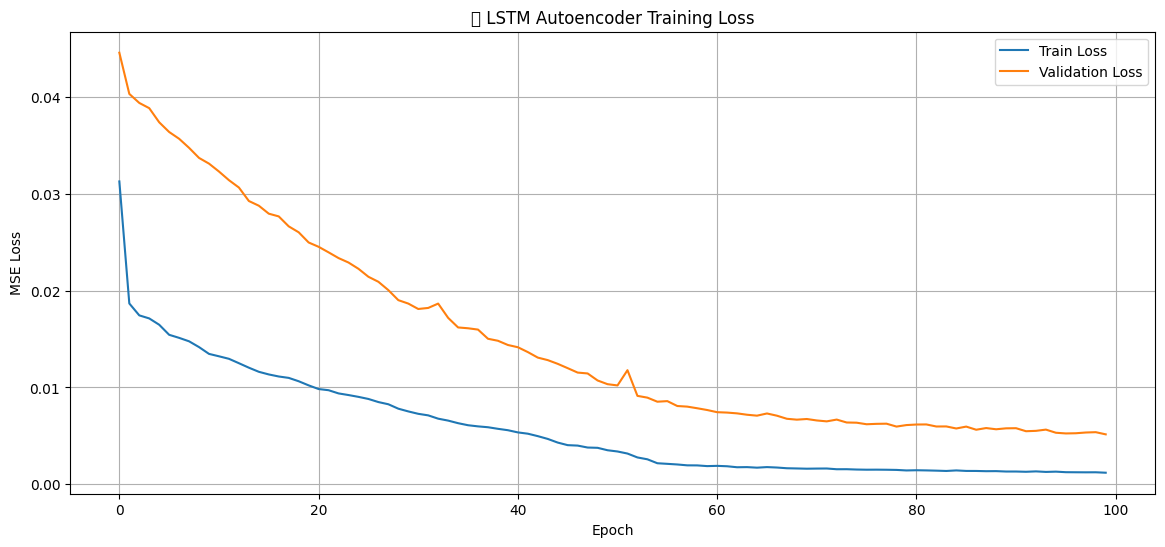

In [4]:
# ========== Sequence Generator ==========
def create_sequences(data, seq_len=10):
    sequences = []
    for i in range(len(data) - seq_len):
        seq = data.iloc[i:i+seq_len].values
        if np.any(np.isnan(seq)) or np.any(np.isinf(seq)):
            continue
        sequences.append(seq)
    return np.array(sequences)

# Set sequence window size
SEQUENCE_LENGTH = 10

# Generate sequences
X_train_seq = create_sequences(X_normal, SEQUENCE_LENGTH)
X_attack_seq = create_sequences(X_attack, SEQUENCE_LENGTH)

print(f"📦 Training sequences shape: {X_train_seq.shape}")
print(f"🧪 Attack sequences shape: {X_attack_seq.shape}")

# ========== LSTM Autoencoder Model ==========
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping

def build_lstm_autoencoder(seq_len, num_features):
    inputs = Input(shape=(seq_len, num_features))
    encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
    repeated = RepeatVector(seq_len)(encoded)
    decoded = LSTM(64, activation='relu', return_sequences=True)(repeated)
    outputs = TimeDistributed(Dense(num_features))(decoded)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Build and summarize model
model = build_lstm_autoencoder(SEQUENCE_LENGTH, X_train_seq.shape[2])
model.summary()

# ========== Train the Model ==========
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_seq, X_train_seq,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stop],
                    verbose=1)

# ========== Plot Training and Validation Loss ==========
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("📉 LSTM Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# ========== Predict & Score Attack Sequences ==========
X_pred = model.predict(X_attack_seq)
mse_scores = np.mean(np.mean(np.square(X_pred - X_attack_seq), axis=2), axis=1)

print(f"✅ Computed MSE scores for {len(mse_scores)} sequences.")

# ========== Align Scores Back to attack.log ==========
# Align each MSE score to the center message of each sequence
aligned_indices = list(range(SEQUENCE_LENGTH//2, SEQUENCE_LENGTH//2 + len(mse_scores)))
df_attack_proc = df_attack_proc.iloc[:len(df_attack_proc)].reset_index(drop=True)
df_attack_proc = df_attack_proc.iloc[aligned_indices].copy()
df_attack_proc['anomaly_score'] = mse_scores

# ========== Top 5 Suspicious CAN IDs ==========
top5_ids = (
    df_attack_proc.groupby('can_id')['anomaly_score']
    .mean()
    .sort_values(ascending=False)
    .head(5)
)
print("🚨 Top 5 suspicious CAN IDs (based on anomaly score):")
print(top5_ids)

# ========== Visualization ==========
import plotly.graph_objects as go

def plot_top5_canid_anomalies(df_proc, top_ids):
    fig = go.Figure()
    for cid in top_ids.index:
        df_sub = df_proc[df_proc['can_id'] == cid]
        fig.add_trace(go.Scatter(
            x=df_sub['timestamp'],
            y=df_sub['anomaly_score'],
            mode='lines+markers',
            name=f'CAN ID {hex(cid)}',
        ))

    fig.update_layout(
        title="🕵️ Top 5 Suspicious CAN IDs by Anomaly Score (Time Series)",
        xaxis_title="Timestamp",
        yaxis_title="Anomaly Score (MSE)",
        height=600,
        template="plotly_dark"
    )
    fig.show()

plot_top5_canid_anomalies(df_attack_proc, top5_ids)


136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
✅ Computed MSE scores for 4343 sequences.
🚨 Top 5 suspicious CAN IDs (based on anomaly score):
can_id
392    0.032000
411    0.016072
580    0.014244
Name: anomaly_score, dtype: float64


In [6]:
# ========== Section 6: Individual Time Graphs of Top 5 Suspicious CAN IDs ==========

def plot_individual_canid_anomalies(df_proc, top_ids, threshold=None):
    for cid in top_ids.index:
        df_sub = df_proc[df_proc['can_id'] == cid]
        hex_id = hex(cid)

        # Auto threshold: 95th percentile of all scores
        thresh = threshold if threshold else df_proc['anomaly_score'].quantile(0.95)

        fig = go.Figure()

        # Anomaly score trace
        fig.add_trace(go.Scatter(
            x=df_sub['timestamp'],
            y=df_sub['anomaly_score'],
            mode='lines+markers',
            name=f'CAN ID {hex_id}',
            line=dict(width=2),
        ))

        # Threshold zone line
        fig.add_trace(go.Scatter(
            x=df_sub['timestamp'],
            y=[thresh]*len(df_sub),
            mode='lines',
            name='Anomaly Threshold',
            line=dict(color='red', dash='dash')
        ))

        # High anomaly zone shading
        fig.add_trace(go.Scatter(
            x=df_sub[df_sub['anomaly_score'] > thresh]['timestamp'],
            y=df_sub[df_sub['anomaly_score'] > thresh]['anomaly_score'],
            mode='markers',
            name='⚠ High Anomaly',
            marker=dict(size=8, color='orange', symbol='circle-open')
        ))

        fig.update_layout(
            title=f"📈 Anomaly Score Timeline for CAN ID {hex_id}",
            xaxis_title="Timestamp",
            yaxis_title="Anomaly Score (MSE)",
            height=450,
            template="plotly_dark",
            legend=dict(x=0.01, y=0.99)
        )
        fig.show()

# Call the function
plot_individual_canid_anomalies(df_attack_proc, top5_ids)


In [7]:
# ========== Section 7A: Mahalanobis Distance Scoring ==========

from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv

def compute_mahalanobis_scores(X_true, X_pred):
    """
    Calculates Mahalanobis distance for each timestep in LSTM sequence reconstruction.
    Returns: List of average sequence-wise Mahalanobis scores
    """
    errors = X_true - X_pred
    errors_flat = errors.reshape(-1, errors.shape[-1])

    # Covariance of error vectors
    cov = np.cov(errors_flat.T)
    cov_inv = inv(cov)

    m_scores = []
    for seq in errors:
        dists = [mahalanobis(vec, np.zeros_like(vec), cov_inv) for vec in seq]
        m_scores.append(np.mean(dists))
    return np.array(m_scores)

# Compute Mahalanobis distances on attack reconstruction
mahal_scores = compute_mahalanobis_scores(X_attack_seq, X_pred)

# Append to dataframe
df_attack_proc_mahal = df_attack_proc.copy()
df_attack_proc_mahal['mahalanobis_score'] = mahal_scores

# Show top 5 CAN IDs by Mahalanobis anomaly score
top5_mahal = (
    df_attack_proc_mahal.groupby('can_id')['mahalanobis_score']
    .mean()
    .sort_values(ascending=False)
    .head(5)
)
print("📌 Top 5 CAN IDs by Mahalanobis score:")
print(top5_mahal)


📌 Top 5 CAN IDs by Mahalanobis score:
can_id
392    2.372966
411    1.833756
580    1.639448
Name: mahalanobis_score, dtype: float64


In [8]:
# ========== Section 7B: Entropy Visualization ==========

def plot_entropy_per_canid(df_proc, top_ids):
    for cid in top_ids.index:
        df_sub = df_proc[df_proc['can_id'] == cid]
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=df_sub['timestamp'],
            y=df_sub['byte_entropy'],
            mode='lines+markers',
            name=f'CAN ID {hex(cid)}',
        ))

        fig.update_layout(
            title=f"🔐 Entropy Over Time for CAN ID {hex(cid)}",
            xaxis_title="Timestamp",
            yaxis_title="Shannon Entropy",
            template="plotly_dark",
            height=400
        )
        fig.show()

# Call for top 5 from MSE or Mahalanobis
plot_entropy_per_canid(df_attack_proc, top5_ids)


🧠 Generating heatmap for CAN ID 0x188...


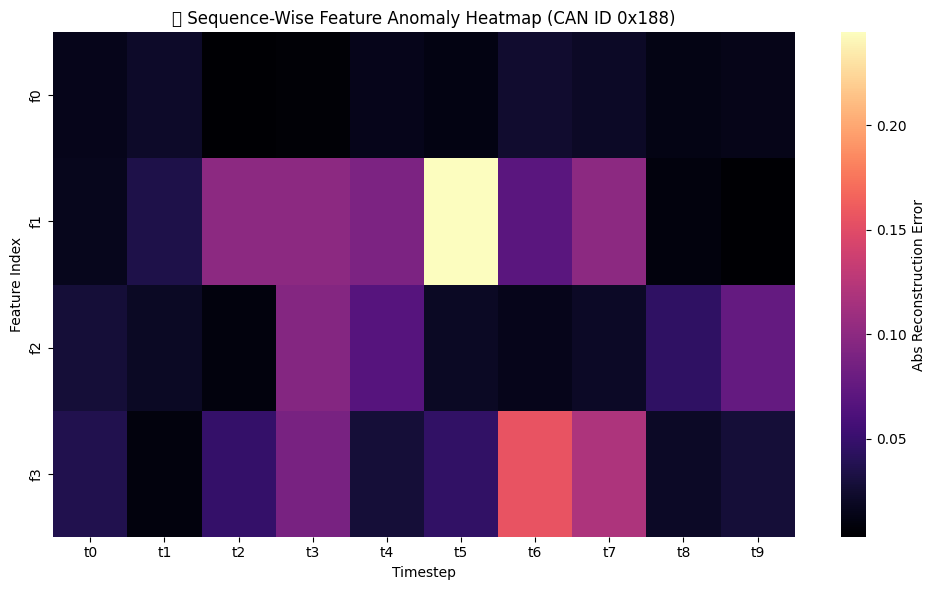

🧠 Generating heatmap for CAN ID 0x19b...


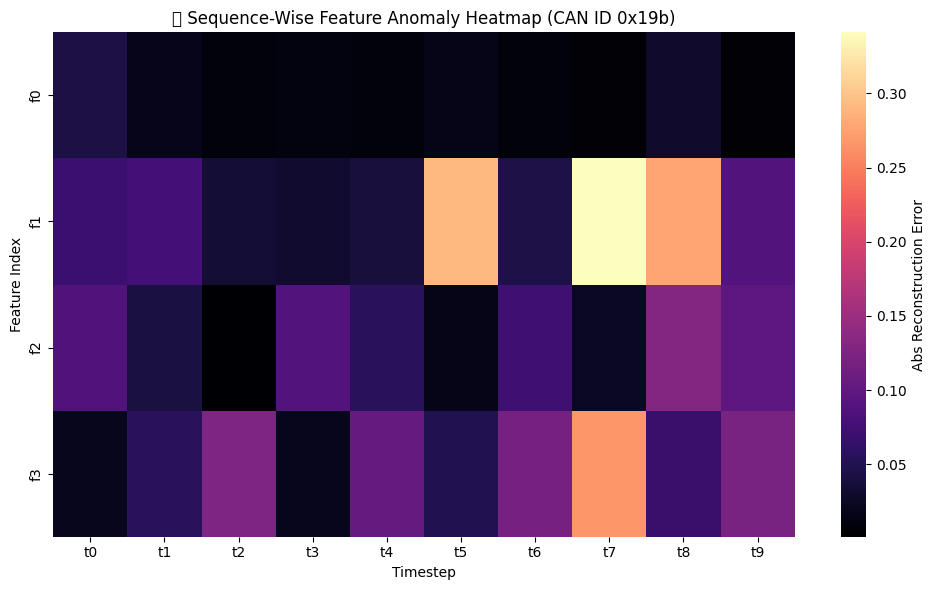

🧠 Generating heatmap for CAN ID 0x244...


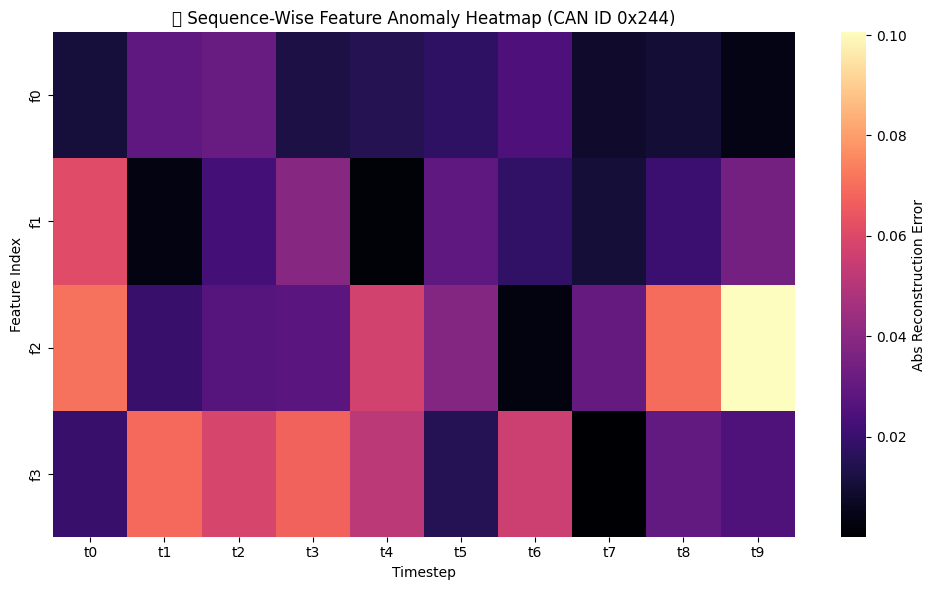

In [12]:
# ========== Section 7C: Sequence-wise Feature Anomaly Heatmaps for Top 5 CAN IDs ==========

def plot_anomaly_heatmap(seq_true, seq_pred, can_id=None):
    """
    Visualize feature-wise reconstruction errors as a heatmap.
    Inputs:
        seq_true: (timesteps x features)
        seq_pred: (timesteps x features)
    """
    seq_true = np.asarray(seq_true)
    seq_pred = np.asarray(seq_pred)

    if seq_true.shape != seq_pred.shape:
        print("❌ Error: Input shapes do not match.")
        print(f"True shape: {seq_true.shape}, Pred shape: {seq_pred.shape}")
        return

    error_matrix = np.abs(seq_true - seq_pred)  # shape: (timesteps, features)

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        error_matrix.T,
        cmap='magma',
        xticklabels=[f"t{i}" for i in range(error_matrix.shape[0])],
        yticklabels=[f"f{i}" for i in range(error_matrix.shape[1])],
        cbar_kws={'label': 'Abs Reconstruction Error'}
    )
    plt.title(f"🔥 Sequence-Wise Feature Anomaly Heatmap {f'(CAN ID {hex(can_id)})' if can_id else ''}")
    plt.xlabel("Timestep")
    plt.ylabel("Feature Index")
    plt.tight_layout()
    plt.show()

# ========== Loop Over Top 5 CAN IDs and Generate One Heatmap Each ==========

for can_id in top5_ids.index:
    indices = df_attack_proc[df_attack_proc['can_id'] == can_id].index

    # Find a valid aligned sequence index (center of original sequence)
    aligned_seq_idx = None
    for idx in indices:
        seq_idx = idx - SEQUENCE_LENGTH // 2
        if 0 <= seq_idx < len(X_attack_seq):
            aligned_seq_idx = seq_idx
            break

    if aligned_seq_idx is not None:
        print(f"🧠 Generating heatmap for CAN ID {hex(can_id)}...")
        plot_anomaly_heatmap(X_attack_seq[aligned_seq_idx], X_pred[aligned_seq_idx], can_id=can_id)
    else:
        print(f"⚠️ Skipped CAN ID {hex(can_id)}: No matching sequence index.")



In [15]:
# ========== Section 8I: Enhanced Interpretability (Dynamic Threshold + Entropy Delta) ==========

def compute_dynamic_thresholds(df_proc, score_column='anomaly_score', quantile=0.95):
    """
    Calculate per-CAN ID anomaly score threshold using given quantile.
    """
    thresholds = df_proc.groupby('can_id')[score_column].quantile(quantile)
    print("📏 Dynamic thresholds computed per CAN ID.")
    return thresholds

# Get per-CAN thresholds
dynamic_thresh = compute_dynamic_thresholds(df_attack_proc, score_column='anomaly_score')

# Apply dynamic flags
df_attack_proc['anomaly_flag_dynamic'] = df_attack_proc.apply(
    lambda row: row['anomaly_score'] > dynamic_thresh.get(row['can_id'], np.inf), axis=1
)

# Compute per-CAN entropy diff
entropy_normal = df_normal_proc.groupby('can_id')['byte_entropy'].mean()
entropy_attack = df_attack_proc.groupby('can_id')['byte_entropy'].mean()
entropy_diff = (entropy_attack - entropy_normal).dropna()

# Combine into a new DataFrame for interpretability ranking
can_summary = pd.DataFrame({
    'dynamic_threshold': dynamic_thresh,
    'entropy_diff': entropy_diff,
    'dynamic_hits': df_attack_proc[df_attack_proc['anomaly_flag_dynamic']]
        .groupby('can_id').size()
})

can_summary = can_summary.fillna(0)
can_summary['score'] = can_summary['entropy_diff'].abs() + can_summary['dynamic_hits']
can_summary = can_summary.sort_values(by='score', ascending=False)

# Display top N CAN IDs in hex
N = 5
print(f"🔍 Top {N} Suspicious CAN IDs by Combined Interpretability Metrics:\n")
for idx, row in can_summary.head(N).iterrows():
    print(f"CAN ID: {hex(idx)} | Entropy Δ: {row['entropy_diff']:.4f} | Dynamic Hits: {int(row['dynamic_hits'])}")


📏 Dynamic thresholds computed per CAN ID.
🔍 Top 5 Suspicious CAN IDs by Combined Interpretability Metrics:

CAN ID: 0x244 | Entropy Δ: 0.0014 | Dynamic Hits: 129
CAN ID: 0x19b | Entropy Δ: 0.5094 | Dynamic Hits: 85
CAN ID: 0x188 | Entropy Δ: -0.0176 | Dynamic Hits: 4


In [18]:
# ========== Section 8G: LSTM-VAE Architecture Placeholder ==========

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_lstm_vae(timesteps, features, latent_dim=16):
    # Encoder
    inputs = Input(shape=(timesteps, features))
    encoded = LSTM(64, return_sequences=True)(inputs)
    encoded = LSTM(32)(encoded)

    z_mean = Dense(latent_dim)(encoded)
    z_log_var = Dense(latent_dim)(encoded)
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Decoder
    decoded = RepeatVector(timesteps)(z)
    decoded = LSTM(32, return_sequences=True)(decoded)
    decoded = LSTM(64, return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(features))(decoded)

    vae = Model(inputs, outputs)
    return vae
